# Lab 2: Cats vs Dogs

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.



## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/file/d/11fEYo3FdDna9bLd5sfuOKz6D7HRsI35I/view?usp=sharing

In [0]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [0]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Returns the indices for datapoints in the dataset that
    belongs to the desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_train_indices = get_relevant_indices(
            trainset,
            classes,
            target_classes)
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_train_indices)
    split = int(len(relevant_train_indices) * 0.8)
    relevant_train_indices, relevant_val_indices = relevant_train_indices[:split], relevant_train_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [0]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

0it [00:00, ?it/s]

170500096it [00:02, 64234955.29it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

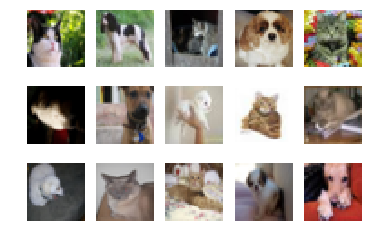

In [0]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [0]:
train_num = len(train_loader) #gives number of training images
test_num = len(test_loader) #gives number of testing images
val_num = len(val_loader) #gives number of validation images

print('The number of training images, testing images and validation images are: %d, %d, %d, respectively' %(train_num, test_num, val_num))

The number of training images, testing images and validation images are: 8000, 2000, 2000, respectively


Since for each category, there are 6000 images, there are a total of 12000 images in the 2 categories (this is confirmed by reviewing the documentation of the images on the link provided). There are 8000 training images and 2000 testing and validation images. 

### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

We need a validation set when training our model to perform a sanity check that our training model did overfit with the training data. If we do not use a validation set loss/error and solely rely on the training loss/error, we may have a false assumption of the model's accuracy because the model is only telling up about accuracy of the training subset, which could be skewed and not representative of the data population (which includes validation and test data)

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [0]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [0]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [0]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [0]:
small_param_num = 0 
large_param_num = 0 

for param in small_net.parameters():
    small_param_num = small_param_num + param.numel()

for param in large_net.parameters():
    large_param_num = large_param_num + param.numel()

    
print("The number of large and small parameters are: %d and %d, respectively" %(large_param_num, small_param_num))

The number of large and small parameters are: 9705 and 386, respectively


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

<img src="Diagram.png" width=60%>

In [0]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [0]:
print("Default parameters of batch size, learning rate and number of epochs are: 64, 0.01 and 30, respectively")

Default parameters of batch size, learning rate and number of epochs are: 64, 0.01 and 30, respectively


### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

When train_net and small_net are called and trained for 5 epochs, there are 4 .csv files  that are generated (which contain the values on the validation error/loss values and the train error/values) for the final epoch, and a disk file that saves the current version of the neural network that was developed per epoch (i.e. 5 disk output files).

Then names of the outputs are as follows: 

Disk files: model_small_bs64_lr0.01_epoch0, model_small_bs64_lr0.01_epoch1, model_small_bs64_lr0.01_epoch2, model_small_bs64_lr0.01_epoch3, model_small_bs64_lr0.01_epoch4

CSV Files: model_small_bs64_lr0.01_epoch4_train_err.csv, model_small_bs64_lr0.01_epoch4_train_loss.csv, model_small_bs64_lr0.01_epoch4_val_err.csv, model_small_bs64_lr0.01_epoch4_val_loss.csv



### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [0]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import time

#Training of the small network
starttime1 = time.time() 
small_boi = train_net(small_net, batch_size=64, learning_rate=0.01, num_epochs=30)
endtime1 = time.time()

#Training of the large network
starttime2 = time.time()
large_boi = train_net(large_net, batch_size=64, learning_rate=0.01, num_epochs=30)
endtime2 = time.time()

diff1 = endtime1 - starttime1
diff2 = endtime2 - starttime2

print('Time for small and large are: %d and %d seconds, respectively' %(diff1, diff2))

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.34025, Train loss: 0.6154966349601746 |Validation err: 0.3395, Validation loss: 0.6248128060251474
Epoch 2: Train err: 0.32575, Train loss: 0.6073013358116149 |Validation err: 0.34, Validation loss: 0.6247400939464569
Epoch 3: Train err: 0.32825, Train loss: 0.6055825242996216 |Validation err: 0.3475, Validation loss: 0.6169721372425556
Epoch 4: Train err: 0.322625, Train loss: 0.6015834851264954 |Validation err: 0.3545, Validation loss: 0.6272775735706091
Epoch 5: Train err: 0.317875, Train loss: 0.5970732519626617 |Validation err: 0.331, Validation loss: 0.6149272155016661
Epoch 6: Train err: 0.318, Train loss: 0.5929429953098297 |Validation err: 0.3405, Validation loss: 0.6199154146015644
Epoch 7: Train err: 0.315375, Train loss: 0.5914552083015442 |Validation err: 0.342, Validation loss: 0.6151098888367414
Epoch 8: Train err: 0.309125, Train loss: 0.5852870161533356 |Validation err: 0.

The large network took ~17 seconds longer to train, because it had more parameters (from the convolutional neural network dimensions) and thus required more computations which increased end-to-end time to completion

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

In [0]:
small_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
large_path = get_model_name("large", batch_size = 64, learning_rate = 0.01, epoch = 29)

Plots for the Small NN: 


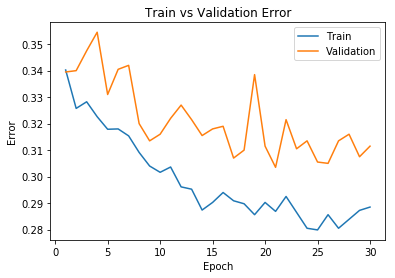

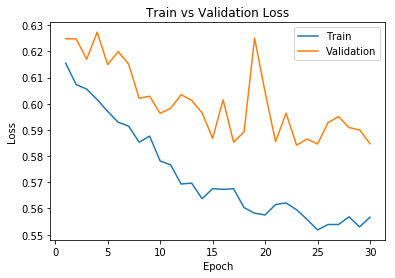

Plots for the Large NN: 


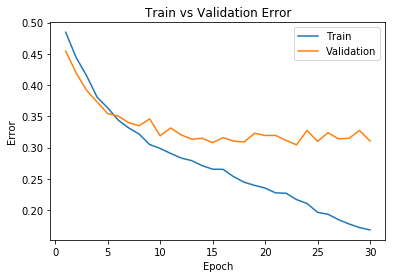

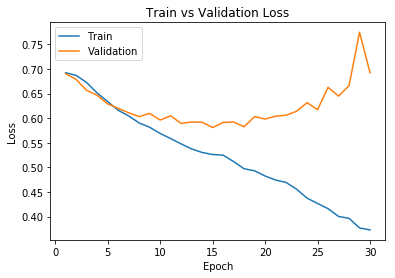

In [0]:
print("Plots for the Small NN: ")
plot_training_curve(small_path)
print("Plots for the Large NN: ")
plot_training_curve(large_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

For the training set in the small net, the train loss/error were significantly higher than on the larger neural network. However, when we compare the validation error, it shows that they both tend to be similar and the validation loss on the large neural network is significantly higher.

The training validation/loss curves for the large neural network are much smoother and are subject to less variation than the smaller neural network (likely because of the higher number of parameters which attenuate noise from the data).

This is important to note, because it appears the large neural network was overfitted to the training data (thus having a very high accuracy and low error on the training set), however when this is applied on the validation set, we see the error and loss start to increase after ~7 epochs (there is divergence between the 2 curves) because the validation data has different characteristics than the training set, which means that the model cannot perform as well. 


## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [0]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, learning_rate=0.001)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.500625, Train loss: 0.6927485518455505 |Validation err: 0.4915, Validation loss: 0.6922051142901182
Epoch 2: Train err: 0.49175, Train loss: 0.6923298530578613 |Validation err: 0.466, Validation loss: 0.6919159535318613
Epoch 3: Train err: 0.456, Train loss: 0.6919747443199158 |Validation err: 0.4355, Validation loss: 0.6916168499737978
Epoch 4: Train err: 0.439375, Train loss: 0.691593117237091 |Validation err: 0.4235, Validation loss: 0.6911521535366774
Epoch 5: Train err: 0.43975, Train loss: 0.6910816459655762 |Validation err: 0.4205, Validation loss: 0.6908283457159996
Epoch 6: Train err: 0.435125, Train loss: 0.6904532194137574 |Validation err: 0.42, Validation loss: 0.689882330596447
Epoch 7: Train err: 0.438125, Train loss: 0.6896609330177307 |Validation err: 0.42, Validation loss: 0.6891869511455297
Epoch 8: Train err: 0.43525, Train loss: 0.6886126198768616 |Validation err: 0.416

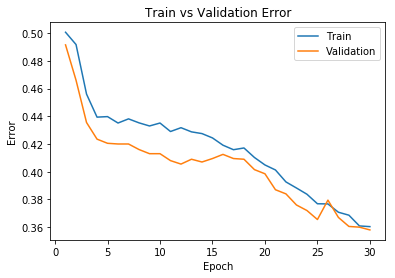

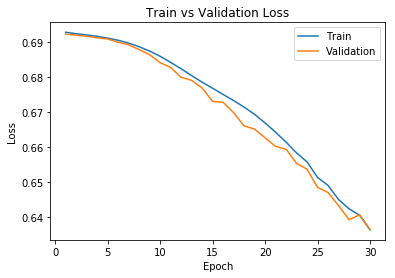

In [0]:
large_path2 = get_model_name("large", batch_size = 64, learning_rate = 0.001, epoch = 29)
plot_training_curve(large_path2)

The model took ~4 less seconds to train than in the original case. 

It is evident that the validation loss/error are more closely fitted. This means that an solution has been reached within 30 epochs that did not involve the overfitting of training data, which means that this model can likely generate more consistent results for all data of the same format/variety of the input.


### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.426875, Train loss: 0.6742900676727295 |Validation err: 0.3695, Validation loss: 0.6364889536052942
Epoch 2: Train err: 0.361625, Train loss: 0.6373908457756042 |Validation err: 0.3655, Validation loss: 0.6439082939177752
Epoch 3: Train err: 0.371625, Train loss: 0.6370397086143493 |Validation err: 0.3515, Validation loss: 0.6133540160953999
Epoch 4: Train err: 0.348, Train loss: 0.6141975626945496 |Validation err: 0.3365, Validation loss: 0.6044933125376701
Epoch 5: Train err: 0.333875, Train loss: 0.6029216282367706 |Validation err: 0.3245, Validation loss: 0.5935317613184452
Epoch 6: Train err: 0.3175, Train loss: 0.5871682240962982 |Validation err: 0.324, Validation loss: 0.5884642750024796
Epoch 7: Train err: 0.308, Train loss: 0.5718630583286285 |Validation err: 0.3095, Validation loss: 0.5934673277661204
Epoch 8: Train err: 0.306625, Train loss: 0.5659790558815002 |Validation err: 0

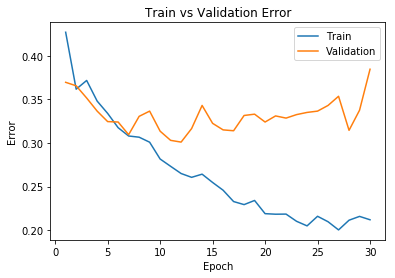

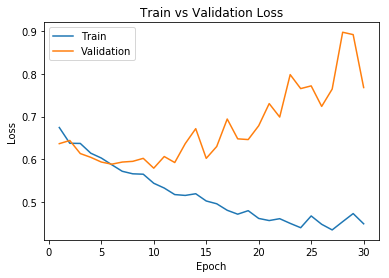

In [0]:
large_net = LargeNet()
train_net(large_net, learning_rate=0.1)
large_path3 = get_model_name("large", batch_size = 64, learning_rate = 0.1, epoch = 29)
plot_training_curve(large_path3)

The time to train the data was 99 seconds which was 1 second less than the last case. By increasing the learning rate, we can see that the model yet again overfit the training data, resulting in a divergence and higher error/loss in the validation data. The interesting part of this case, is that the training loss/error was lower than the initial case when the lr=0.01, which means that the higher coefficient did not allow for the neural network to find a "global" minimum as well as the first model did, which means that even though the data is overfit, there is a threshold of ~45% of accuracy for which this model can achieve. 

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379403591156 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924103908240795 |Validation err: 0.434, Validation loss: 0.6917425096035004
Epoch 3: Train err: 0.437, Train loss: 0.6916500441730022 |Validation err: 0.4265, Validation loss: 0.6909130066633224
Epoch 4: Train err: 0.433625, Train loss: 0.6908450052142143 |Validation err: 0.424, Validation loss: 0.6897870898246765
Epoch 5: Train err: 0.434, Train loss: 0.6896936446428299 |Validation err: 0.424, Validation loss: 0.6881358623504639
Epoch 6: Train err: 0.43825, Train loss: 0.6883534081280231 |Validation err: 0.428, Validation loss: 0.68601293861866
Epoch 7: Train err: 0.439375, Train loss: 0.6866869702935219 |Validation err: 0.426, Validation loss: 0.6836968064308167
Epoch 8: Train err: 0.435375, Train loss: 0.6849769502878189 |Validation err: 0.412, V

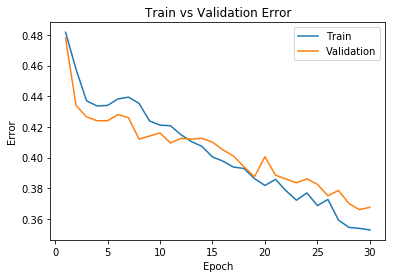

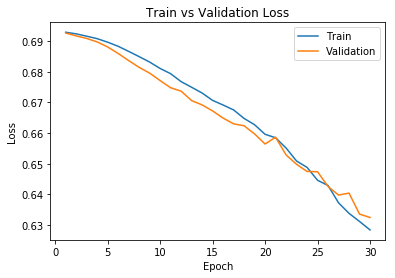

In [0]:
large_net = LargeNet()
train_net(large_net, batch_size=512)
large_path4 = get_model_name("large", batch_size = 512, learning_rate = 0.01, epoch = 29)
plot_training_curve(large_path4)

This model took ~91 seconds to train (the shortest training time yet). This makes sense, because the amount of iterations that had to be processed by the network were decreased (due to the higher batch size). 

Similar to when the learning rate was decreased, increasing the batch size resulted in no overfitting of the model to the training data which allows for more consistent loss/error results across the training/validation set. 

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774821187257767 |Validation err: 0.378, Validation loss: 0.651921395778656
Epoch 2: Train err: 0.36875, Train loss: 0.6395755406022072 |Validation err: 0.3595, Validation loss: 0.6264406447410583
Epoch 3: Train err: 0.33875, Train loss: 0.6120929001569748 |Validation err: 0.3475, Validation loss: 0.6289729187488556
Epoch 4: Train err: 0.314375, Train loss: 0.5869516692757607 |Validation err: 0.3545, Validation loss: 0.6142054274082184
Epoch 5: Train err: 0.3115, Train loss: 0.5694829801917076 |Validation err: 0.312, Validation loss: 0.5763112711906433
Epoch 6: Train err: 0.281125, Train loss: 0.5458917077481746 |Validation err: 0.2985, Validation loss: 0.5741617560386658
Epoch 7: Train err: 0.269875, Train loss: 0.5297637034058571 |Validation err: 0.309, Validation loss: 0.6013907868862152
Epoch 8: Train err: 0.257375, Train loss: 0.5129605046510697 |Validation err: 0

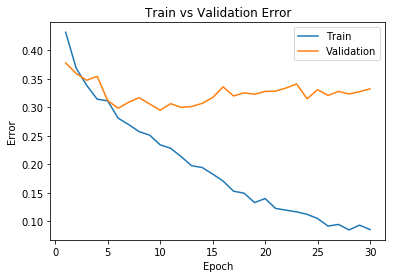

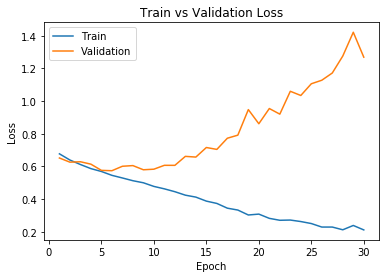

In [0]:
large_net = LargeNet()
train_net(large_net, batch_size=16)
large_path5 = get_model_name("large", batch_size = 16, learning_rate = 0.01, epoch = 29)
plot_training_curve(large_path5)

Decreasing the batch size resulted in the highest time to train of ~150 seconds (which makes sense because the number of iterations would have had to increase). 

Once again, it seems that the model overfit the training data which created a divergence and inconsistency when it came to the validation loss/error. However in this instance, it seems the actual error and loss were at record levels compared to the previous cases which means that the model may have actually overfit in a way that created more error in the calculation of the data which is more than 100% (i.e. more than 100% wrong).

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

Based on the information collected above, it would seem best to use a lower learning rate, with a larger batch size (since both contributed to no overfitting) and a large neural network (since it has more parameters to train a more accurate model). 

I will try a batch size of 768 (slightly higher) and a learning rate of 0.001

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.488875, Train loss: 0.6930893334475431 |Validation err: 0.4965, Validation loss: 0.6931172609329224
Epoch 2: Train err: 0.486625, Train loss: 0.6930157000368292 |Validation err: 0.497, Validation loss: 0.6930728157361349
Epoch 3: Train err: 0.48375, Train loss: 0.6929911266673695 |Validation err: 0.4965, Validation loss: 0.6930578748385111
Epoch 4: Train err: 0.481, Train loss: 0.6930067485029047 |Validation err: 0.4895, Validation loss: 0.6930401722590128
Epoch 5: Train err: 0.478375, Train loss: 0.6928892027248036 |Validation err: 0.4905, Validation loss: 0.6928780873616537
Epoch 6: Train err: 0.4745, Train loss: 0.6928197904066606 |Validation err: 0.4865, Validation loss: 0.6928342382113138
Epoch 7: Train err: 0.472125, Train loss: 0.6927762519229542 |Validation err: 0.4825, Validation loss: 0.6927417516708374
Epoch 8: Train err: 0.469875, Train loss: 0.6927094893022017 |Validation err:

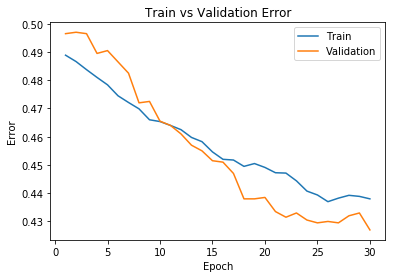

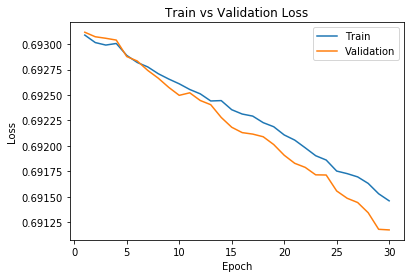

In [0]:
large_net = LargeNet()
train_net(large_net, batch_size=768, learning_rate=0.001, num_epochs=30)
large_pathx = get_model_name("large", batch_size=768, learning_rate=0.001, epoch=29)
plot_training_curve(large_pathx)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

In the results there was no overfitting, but the loss/error was higher than in the previous cases in the last part of the lab. I will try to use a higher learning rate (0.01), while also still reducing the number of batch sizes by 16.67%. I'll also try a small net this time to try to avoid overfitting

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.466875, Train loss: 0.6896705260643592 |Validation err: 0.4585, Validation loss: 0.6753568351268768
Epoch 2: Train err: 0.408625, Train loss: 0.6684273022871751 |Validation err: 0.3795, Validation loss: 0.6475940346717834
Epoch 3: Train err: 0.37975, Train loss: 0.652671048274407 |Validation err: 0.3555, Validation loss: 0.6488861292600632
Epoch 4: Train err: 0.35275, Train loss: 0.6352488398551941 |Validation err: 0.369, Validation loss: 0.6346989125013351
Epoch 5: Train err: 0.351875, Train loss: 0.6283351274637076 |Validation err: 0.3465, Validation loss: 0.6343941688537598
Epoch 6: Train err: 0.336, Train loss: 0.616734096637139 |Validation err: 0.3465, Validation loss: 0.619888037443161
Epoch 7: Train err: 0.32925, Train loss: 0.6085789387042706 |Validation err: 0.3305, Validation loss: 0.619257390499115
Epoch 8: Train err: 0.333875, Train loss: 0.6044721282445468 |Validation err: 0.3

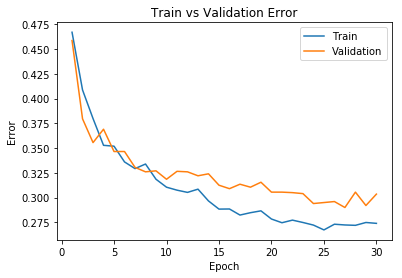

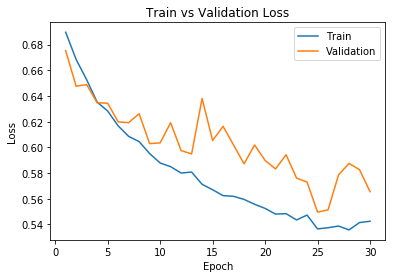

In [0]:
small_net = SmallNet()
train_net(small_net, batch_size=640, learning_rate=0.05, num_epochs=30)
small_pathy = get_model_name("small", batch_size=640, learning_rate=0.05, epoch=29)
plot_training_curve(small_pathy)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [0]:
#Since the small net one was the highest of the bunch, 
net = SmallNet()
model_path = get_model_name(net.name, batch_size=640, learning_rate=0.05, epoch=29)
state = torch.load(model_path)
net.load_state_dict(state)


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### Part (b) - 2pt

Justify your choice of model from part (a).

In order for a model to be optimal, the model should not overfit the training data and also generate minimal loss/error between the training and validation data (thus indicating that the model can consistently predict reality and potentially new data with high accuracy). Since the models where there was overfitting had bad accuracy on the validation data, and the models with no overfitting had low accuracy all around, I used the small_net model with the higher batch size and slightly higher learning rate. This generated slight overfitting in the training data (since there was some divergence and variation in the validation loss), but the mean accuracy in each case was better than the preceeding models.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [0]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=640)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
#Use the evaluate function, and use the Binary Cross Entropy function declared in the train_net function
Err, Loss = evaluate(net, test_loader,nn.BCEWithLogitsLoss())
print("Classification error: ", Err)
print("Classification loss: ", Loss)

Classification error:  0.297
Classification loss:  0.5722097605466843


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [0]:
err, loss = evaluate(net, val_loader, nn.BCEWithLogitsLoss())
print("Validation error: ", err)
print("Validation loss: ", loss)

Validation error:  0.3035
Validation loss:  0.5649506747722626


In this case, my model gives slightly less error on the test data as opposed to the validation data.
S
ince the model is continuously tweaked and optimized to perform well against a valiation set, using a training set the model can be thought of as "validation biased". As such, when a testing set enters the model which may be different than the validation set, if the testing data is different than the validation data by even a slight degree, there is a chance that the model performs more poorly on the testing set (or it could perform better on the testing set if the testing set shares characteristics that align more with the training set than the validation data). 

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

We used thet test set at the end to do a 100% final check of how our model performs against data of cat/dog classification. If we used the test data before in the model, then we would already have insight to the performance of the test data and thus would try to optimize for the test data. Therefore, there would be no true "test" of the model to see how it performs against unpredictable/unknown data.

### Part (f) - 5pt

Train a 2-layer ANN similar to what was used in Lab 1 to classific cats and dogs. Try out different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data. How does the ANN model compare to your CNN model?

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48725, Train loss: 0.6919894833413381 |Validation err: 0.4695, Validation loss: 0.6913558468222618
Epoch 2: Train err: 0.46475, Train loss: 0.6892073182832628 |Validation err: 0.4545, Validation loss: 0.6889091990888119
Epoch 3: Train err: 0.445375, Train loss: 0.6868697149412972 |Validation err: 0.445, Validation loss: 0.687135636806488
Epoch 4: Train err: 0.43675, Train loss: 0.6846548914909363 |Validation err: 0.4435, Validation loss: 0.6850060932338238
Epoch 5: Train err: 0.4285, Train loss: 0.6826564007335238 |Validation err: 0.437, Validation loss: 0.6833678223192692
Epoch 6: Train err: 0.42375, Train loss: 0.6810157384191241 |Validation err: 0.4325, Validation loss: 0.682112455368042
Epoch 7: Train err: 0.4205, Train loss: 0.6793437439297872 |Validation err: 0.433, Validation loss: 0.6804993785917759
Epoch 8: Train err: 0.412625, Train loss: 0.6779041697108557 |Validation err: 0.429

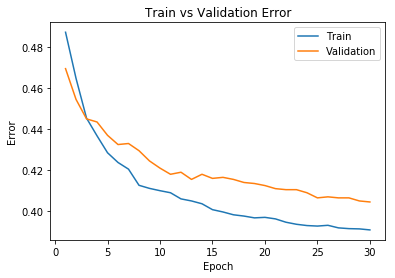

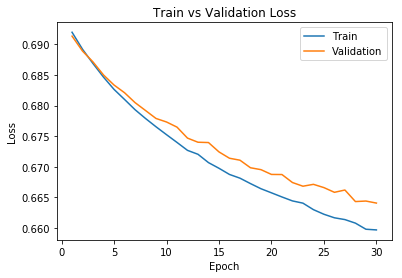

In [0]:
torch.manual_seed(1) # set the random seed - from Lab 1
# define a 2-layer artificial neural network - from Lab 1
class CatDoggo(nn.Module):
    def __init__(self):
        self.name = "CatDoggo"
        super(CatDoggo, self).__init__()
        self.layer1 = nn.Linear(3 * 32*32, 60)
        self.layer2 = nn.Linear(60, 1)
    def forward(self, img):
        flattened = img.view(-1, 3 * 32*32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = activation2.squeeze(1)
        return activation2


#Train the ANN
train_ANN = CatDoggo() #sets the NN as train_ANN
train_net(train_ANN, batch_size = 128, learning_rate=0.0001, num_epochs = 30) #trains and sets a rate of 0.05; determined to be best by my previous experiments

cdpath = get_model_name("CatDoggo", batch_size=128, learning_rate=0.0001, epoch=29) #run the plotting function on the ANN
plot_training_curve(cdpath) #Generate the plots

In [0]:
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=128)

err, loss = evaluate(train_ANN, test_loader, nn.BCEWithLogitsLoss())
print("Test error: ", err)
print("Test loss: ", loss)

Files already downloaded and verified
Files already downloaded and verified
Test error:  0.3835
Test loss:  0.6570412106812


In [0]:
err, loss = evaluate(train_ANN, val_loader, nn.BCEWithLogitsLoss())
print("Validation error: ", err)
print("Validation loss: ", loss)

Validation error:  0.4045
Validation loss:  0.6646832078695297


The error of my ANN for the test and validation data is 0.3835 and 0.4045, respectively. Comparing this to the CNN val/test error (0.297 and 0.305), it is clear the CNN outperforms the ANN at it's best parameterization